# `wwz.py` documentation

The script `wwz.py` implements the weighted wavelet z-transform introduced in [[1]](#references). This notebook demonstrates how to use this code.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from matplotlib.colors import LogNorm
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from wwz import WWZ

In [3]:
plt.rcParams.update({
    'figure.figsize': (16, 4),
    'lines.linestyle': 'None',
    'lines.marker': 'o',
    'lines.markersize': 4,
    })

cmap = cm.get_cmap('Greys')

## Create artificial test data

We create an artificial signal that starts with an oscillation of constant frequency. The oscillation at some points starts to drift to higher frequencies. Then it fades out. At a later point a new oscillation with a different period fades in.

We use a cosine function for the oscillation. The fading in/out is implemented with a sigmoid function of which we can control the location and decay time. The frequency drift is implemented with a linear dependence of the period on time.

In [4]:
def sigmoid(t, t0, decay, sign=-1):
    return 1. / (1. + np.exp(np.sign(sign) * (t - t0) / decay * np.pi * 2))

Data total time: 3547.7


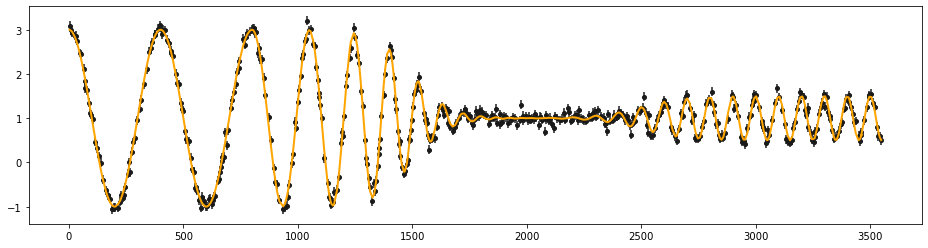

In [5]:
# number of data points:
n = 500

# parameters for first QPO:
qpo0_period = 400.
qpo0_amplitude = 2.
qpo0_decay = 500.
qpo0_decay_t = 1500.
qpo0_drift_factor = -0.0005
qpo0_drift_t = 800.

# parameters for second QPO:
qpo1_period = 100.
qpo1_amplitude = 0.5 
qpo1_decay = 600.
qpo1_decay_t = 2500.

# scale for Gaussian noise:
x_err = 0.1

# create times, signal:
t = np.cumsum(np.random.normal(7, 3, n))
x = np.ones(n)
period_drift = np.where(
        t < qpo0_drift_t,
        qpo0_period,
        qpo0_period + (qpo0_period * qpo0_drift_factor * (t - qpo0_drift_t)))
x += np.cos(t / period_drift * np.pi * 2) * qpo0_amplitude * sigmoid(t, qpo0_decay_t, qpo0_decay, sign=+1)
x += np.cos(t / qpo1_period * np.pi * 2) * qpo1_amplitude * sigmoid(t, qpo1_decay_t, qpo1_decay, sign=-1)
plt.plot(t, x, marker='None', linestyle='-', zorder=1, color='orange', lw=2)

# add noise:
x += np.random.normal(0, x_err, n)
plt.errorbar(t, x, yerr=x_err, zorder=0, color='0.1')

print('Data total time: {0:.1f}'.format(t[-1]))

## Create a `WWZ` instance and add data

We already imported the `WWZ` class from `wwz.py` in the first code cell. This class includes all methods needed to perform the analysis. We create an instance of `WWZ`:

In [6]:
wwz = WWZ()

WWZ instance created.


Next, we hand the data to the class instance using the `set_data()` method; time, flux, and - optionally - flux uncertainties:

In [7]:
wwz.set_data(t, x, x_err)

Data stored.


After running the analysis, the `set_data()` method can be used to hand different data to the same class instance and then run the analysis on these data. It is not necessary to create a separate class instance for each set of data.

As a shortcut it is also possible to set the data when the class instance is created:

In [8]:
wwz = WWZ(t, x, x_err)

WWZ instance created.
Data stored.


## Define frequency and tau ranges

The WWZ transform will be calculated over a range of frequencies, $\nu$,  and a range of points in time, $\tau$. For that we need to provide these to the class instance. First, there are two methods to create the frequency and tau arrays. These arrays define the resolution of the transform in frequency and in time. 

### Create the frequency range

The `WWZ` class has a method `get_freq()` to create an array of frequencies for the analysis. By default the method will use the stored data to determine the lowest and highest frequency that can be reasonably analysed:

In [9]:
freq = wwz.get_freq()

Linear range of frequencies created with
Shortest period:         2.70e+01
Longest period:          7.09e+02
Period interval:       non-linear
Lowest frequency:        1.41e-03
Highest frequency:       3.70e-02
Frequency interval:      3.60e-04
Number of frequencies:        100



We can set the frequency range manually by setting a shortest period, `p_min`, which relates to the highest frequency, and/or a longest period, `p_max`, which relates to the lowest frequency.

In [10]:
freq = wwz.get_freq(p_min=100, p_max=800)

p_min  should not be larger than 709.0.

Linear range of frequencies created with
Shortest period:         1.00e+02
Longest period:          8.00e+02
Period interval:       non-linear
Lowest frequency:        1.25e-03
Highest frequency:       1.00e-02
Frequency interval:      8.84e-05
Number of frequencies:        100



When the selected `p_min` is too short or the selected `p_max` is too long to be reasonably covered by the stored data the method will print out a warning. It will nevertheless create the array and it up to the user whether or not to proceed with it:

In [11]:
freq = wwz.get_freq(p_min=10, p_max=1000)

p_min should  not be shorter than 27.0.

p_min  should not be larger than 709.0.

Linear range of frequencies created with
Shortest period:         1.00e+01
Longest period:          1.00e+03
Period interval:       non-linear
Lowest frequency:        1.00e-03
Highest frequency:       1.00e-01
Frequency interval:      1.00e-03
Number of frequencies:        100



We could first request the suggested shortest and longest period that we use in the frequency range, this allows us to avoid running into the issue above:

In [12]:
wwz.get_period_lims()

(27.0, 709.0)

The shortest period is calculated as the median of the time steps between measurements multiplied by a factor of 4. The longest period is calculated as the total time covered by the data devided by a factor of 5. These default factors are also used in `get_freq()` to determine the shortest and longest period. However, we can also modify those factors in the `get_period_lims()` and the `get_freq()` methods:

In [13]:
print(wwz.get_period_lims(p_min_factor=5, p_max_factor=6))
freq = wwz.get_freq(p_min_factor=5, p_max_factor=6)

(34.0, 591.0)
Linear range of frequencies created with
Shortest period:         3.40e+01
Longest period:          5.91e+02
Period interval:       non-linear
Lowest frequency:        1.69e-03
Highest frequency:       2.94e-02
Frequency interval:      2.80e-04
Number of frequencies:        100



Increasing `p_min_factor` and decreasing `p_min_factor` is a more conservative approach as the frequency range that is tested becomes more narrow. Vice versa, decreasing `p_min_factor` and increasing `p_min_factor` will enlarge the tested frequency range; however, the most extreme frequencies will be less reliable.

By default 100 frequency bins are created. We can manually change the number of bins through the `n_bins` argument:

In [14]:
freq = wwz.get_freq(n_bins=150)

Linear range of frequencies created with
Shortest period:         2.70e+01
Longest period:          7.09e+02
Period interval:       non-linear
Lowest frequency:        1.41e-03
Highest frequency:       3.70e-02
Frequency interval:      2.39e-04
Number of frequencies:        150



We can also set the binning interval for the frequency directly, using `diff`:

In [15]:
freq = wwz.get_freq(diff=0.001)

Linear range of frequencies created with
Shortest period:         2.70e+01
Longest period:          7.09e+02
Period interval:       non-linear
Lowest frequency:        1.41e-03
Highest frequency:       3.70e-02
Frequency interval:      1.00e-03
Number of frequencies:         36



By default, `get_freq()` creates and array of equally spaced frequencies. Consequentially, the corresponding periods, which relate to the frequencies, $\nu$, as $1/\nu$, are not linearly spaced. If we want to run the analysis on linearly space periods, we can do that by setting `linear_period=True`. All of the above options work in the same way as before. However, `diff` now relates to the difference between periods:

In [16]:
freq = wwz.get_freq(diff=10, linear_period=True)

Linear range of frequencies created with
Shortest period:         2.70e+01
Longest period:          7.09e+02
Period interval:         1.00e+01
Lowest frequency:        1.41e-03
Highest frequency:       3.70e-02
Frequency interval:    non-linear
Number of frequencies:         69



### Create the tau (time point) range

The `WWZ` class has a method `get_tau()` to create an array of time points for the analysis. By default the method will use the stored data to determine the earliest and latest time point:

In [17]:
tau = wwz.get_tau()

Linear range of tau (time points) created with
Earliest time:                2.8
Latest time:               3547.7
Time interval:                8.0
Points in time:               443



By default the method calculates the time range of the data and devides it by 8 to define the number of time points. We can also change the binning factor by setting `n_div=8` to a different value. Increasing `n_div` will result in fewer bins:

In [18]:
tau = wwz.get_tau(n_div=10)

Linear range of tau (time points) created with
Earliest time:                2.8
Latest time:               3547.7
Time interval:               10.0
Points in time:               354



Alternatively we can also set the number of time bins directly, using `n_bins`:

In [19]:
tau = wwz.get_tau(n_bins=200)

Linear range of tau (time points) created with
Earliest time:                2.8
Latest time:               3547.7
Time interval:               17.8
Points in time:               200



Finally, we can also set the binning interval for $\tau$ directly, using `dtau`:

In [20]:
tau = wwz.get_tau(dtau=10)

Linear range of tau (time points) created with
Earliest time:                2.8
Latest time:               3547.7
Time interval:               10.0
Points in time:               355



## Set frequency and tau ranges

In [21]:
freq = wwz.get_freq()
tau = wwz.get_tau()
wwz.set_freq(freq)
wwz.set_tau(tau)

Linear range of frequencies created with
Shortest period:         2.70e+01
Longest period:          7.09e+02
Period interval:       non-linear
Lowest frequency:        1.41e-03
Highest frequency:       3.70e-02
Frequency interval:      3.60e-04
Number of frequencies:        100

Linear range of tau (time points) created with
Earliest time:                2.8
Latest time:               3547.7
Time interval:                8.0
Points in time:               443

Frequencies set.
Tau (time points) set.


## Run the WWZ transform analysis

Once we provided the `WWZ` class instance with the data, frequencies, and taus we can run the actual analysis, using the method `transform()`. This method has three optional arguments:
1. `c` defines the window decay. By default it uses the common value, $c=(8\pi^2)^{-1}$, described in [[1]](#references).
1. If `snr_weight` is set to `True`, the fluxes are weighted by their signal-to-noise ratio, calculated from the flux uncertainties that can be provided as data. By default, this SNR weighting is turned off.
1. 'verbose` controls how much information is printed out. Set to `0` to turn off all information. Set to `1` to print the run time. Set to `2` to get additional information about the progress of the code.

We set up the `WWZ`-instance with default values and run the transform, printing out all information:

In [22]:
wwz = WWZ(t, x, x_err)
freq = wwz.get_freq()
tau = wwz.get_tau()
wwz.set_freq(freq)
wwz.set_tau(tau)

wwz.transform(verbose=2)

WWZ instance created.
Data stored.
Linear range of frequencies created with
Shortest period:         2.70e+01
Longest period:          7.09e+02
Period interval:       non-linear
Lowest frequency:        1.41e-03
Highest frequency:       3.70e-02
Frequency interval:      3.60e-04
Number of frequencies:        100

Linear range of tau (time points) created with
Earliest time:                2.8
Latest time:               3547.7
Time interval:                8.0
Points in time:               443

Frequencies set.
Tau (time points) set.
Starting the WWZ transform..
Setting frequency-tau-grid..
Creating weights..
Calculating projections and scattering matrix..
Inverting scattering matrix..
Calculating model coefficients..
Calculating elements of transform..
Calculating WWZ and WWA..
Finished in 0:00:05.035835


True

The WWZ and WWA can be retrieved from the class instance as below. Transposing these arrays is required, when the freqency should be plotted along the y-axis and the time should be plotted along the x-axis:

In [23]:
result_wwz = wwz.wwz.transpose()
result_wwa = wwz.wwa.transpose()

Where do we get the strongest signal? The following is a quick test, based on a single analysis pixel. More detailed analysis will follow below:

In [24]:
i, j = np.unravel_index(np.argmax(result_wwz), result_wwz.shape)
print('Strongest signal: {0:10.2e}'.format(result_wwz[i,j]))
print('at frequency:     {0:10.2e}'.format(freq[i]))
print('at period:        {0:10.2e}'.format(1./freq[i]))
print('at time:          {0:10.2e}'.format(tau[j]))

Strongest signal:   7.40e+02
at frequency:       2.49e-03
at period:          4.02e+02
at time:            2.82e+00


Plot the WWZ:

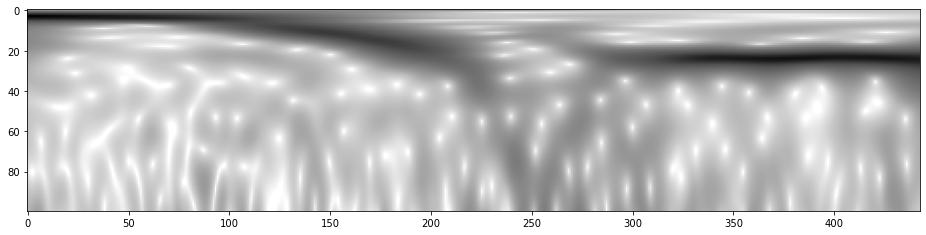

In [25]:
min_trunc_factor = 1000
plt.imshow(result_wwz, cmap=cmap, norm=LogNorm(vmin=result_wwz.min()*min_trunc_factor, vmax=result_wwz.max()))
pass

In [26]:
pd.DataFrame(result_wwz.flatten()).describe()

,0
count,44300.000000
mean,5.206845
std,27.542849
min,0.000002
25%,0.067845
50%,0.203275
75%,0.662549
max,739.754814


Plot the WWA:

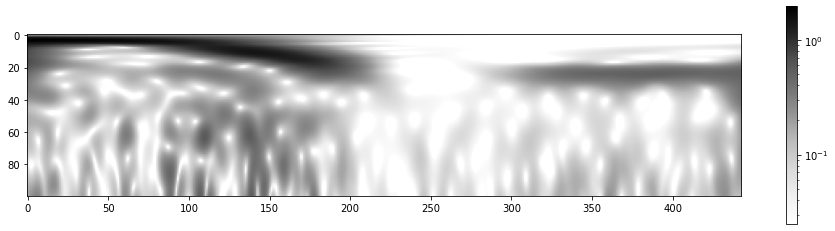

In [27]:
min_trunc_factor = 100
img = plt.imshow(result_wwa, cmap=cmap, norm=LogNorm(vmin=result_wwa.min()*min_trunc_factor, vmax=result_wwa.max()))
plt.colorbar(img)
pass

In [28]:
pd.DataFrame(result_wwa.flatten()).describe()

,0
count,44300.000000
mean,0.150386
std,0.222358
min,0.000249
25%,0.039356
50%,0.078407
75%,0.162783
max,1.956271


## Monte Carlo based significance estimation

To estimate the significance of the WWZ and WWA results, we run the analysis with the same frequencies and taus over a large number of simulations of a certain kind and count for each frequency-tau-bin the number of simulations that produced an equal or stronger signal than the data.
The simulations provide the Null hypothesis, $H0$, that we test against.

For simplicity, we test against Gaussian white noise in the following example. In this case, $H0$ is that the true signal shows no variability and that any deviation from that is uncorrelated noise, described by a Gaussian distribution. We create 100 realisations of such simulated data.

In [29]:
def noise(n, x_err):
    t = np.cumsum(np.random.normal(7, 3, n))
    x = np.random.normal(0, x_err, n)
    return t, x, x_err

In [30]:
n_sim = 100
simulations = [noise(n, x_err) for i in range(n_sim)]
print('{0:d} simulations created.'.format(len(simulations)))

100 simulations created.


Show randomly picked example of the Gaussian white noise simulations:

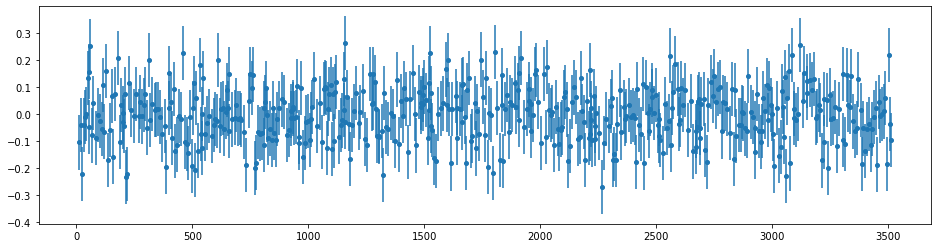

In [31]:
i = np.random.randint(len(simulations))
plt.errorbar(simulations[i][0], simulations[i][1], yerr=simulations[i][2])
pass

For the demonstration of the significance analysis we reset the `WWZ` instance and set it up with fewer time bins. This will reduce the computing time.

In [32]:
wwz = WWZ(t, x, x_err)
freq = wwz.get_freq()
tau = wwz.get_tau(n_bins=200)
wwz.set_freq(freq, verbose=0)
wwz.set_tau(tau, verbose=0)

wwz.transform(verbose=1)
pass

WWZ instance created.
Data stored.
Linear range of frequencies created with
Shortest period:         2.70e+01
Longest period:          7.09e+02
Period interval:       non-linear
Lowest frequency:        1.41e-03
Highest frequency:       3.70e-02
Frequency interval:      3.60e-04
Number of frequencies:        100

Linear range of tau (time points) created with
Earliest time:                2.8
Latest time:               3547.7
Time interval:               17.8
Points in time:               200

Starting the WWZ transform..
Finished in 0:00:02.389066


### Analyse simulations

To run the significance estimation we hand the list of simulations to the `estimate_significance()` method. The list of simulations needs to be set up as follows. Each item in the list is one simulation. `estimate_significance()` iterates over that list. Each simulation has to be stored in a list or tuple of two or three entries. The first provides the time, the second provides the fluxes, the third provides the uncertainties. The third is optional.

In [33]:
wwz.estimate_significance(simulations)
pass

WWZ instance created.
Starting analysis of simulations at 2021-09-12 14:21:27.776160
Finished in 0:03:30.188408%


What this method does is the following, while iterating through the provided simulations:
1. The WWZ and WWA are calculated for the simulation.
1. It is checked for which frequency-tau-bins the simulation-based WWZ gives a larger value, i.e. a stronger signal than found in the data-based WWZ. The same is done for WWA.
1. An array of the same shape as the WWZ, called `wwz_sig` intially starts with all zeros. The count is increased by 1, where the simulation resulted in a stronger signal than the data. The same is done for WWA, with an array named  `wwa_sig`. Additionally a counter that keeps track of the number of simulations that were analysed is also increased by 1.
1. Finally, after all iterations have finished, the corresponding p-values are calculated by deviding the two counter-arrays by the number of simulations. The results are stored in two new arrays, `wwz_pval` and `wwa_pval`.

#### Extracting the results

We can access the counter arrays and p-value arrays as follows:

In [34]:
result_wwz_sig = wwz.wwz_sig.transpose()
result_wwz_pval = wwz.wwz_pval.transpose()

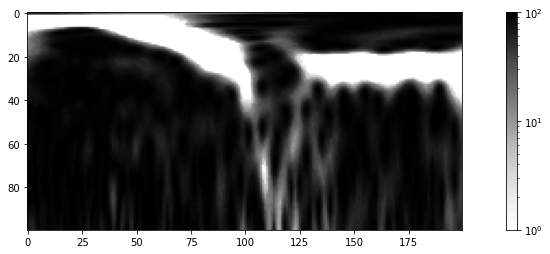

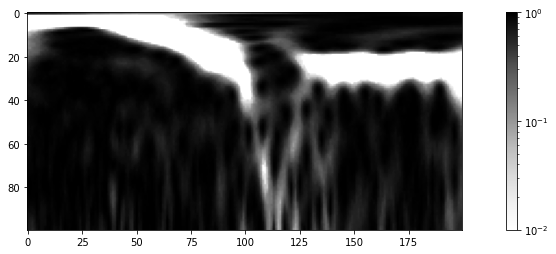

In [35]:
img = plt.imshow(result_wwz_sig, cmap=cmap, norm=LogNorm())
plt.colorbar(img)
plt.figure()
img = plt.imshow(result_wwz_pval, cmap=cmap, norm=LogNorm())
plt.colorbar(img)
pass

The images are showing identical information. Only the scaling is different, as can be seen in the colorbars. The p-values are normalized to the interval [0,1] and as such are more usefull than the total counts. Therefore, in the following we will only look at the p-values.

In [36]:
pd.DataFrame(result_wwz_pval.flatten()).describe()

,0
count,20000.000000
mean,0.679527
std,0.328229
min,0.000000
25%,0.520000
50%,0.810000
75%,0.930000
max,1.000000


*A quick side-note on hypothesis testing.*

**Interpretation of the p-values:** The p-value at a specified frequency-tau-bin gives us an estimate of the probability that the simulations, which are based on our null-hypothesis, $H0$ result in a signal equally as or stronger than the signal of the real data. If that probability is low, we reject $H0$. *Low* means lower than a predefined significance level. E.g. if we choose a significance level of 5% (which roughly corresponds to $2\sigma$), a p-value of less than 5% would allow us to reject $H0$ at the 5%-significance level. The implication in the example here would be that at this frequency-tau-bin the signal is not a result of Gaussian white noise. Instead we accept the alternative hypothesis $H1$ that the signal is a result of periodicity. (The premise here is that $H0$ and $H1$ are complementary and the only options.) If the p-value exceeds 5% we cannot reject $H0$ and thus can neither claim that the measured signal is a result of periodicity ($H1$) nor Gaussian noise ($H1$). The latter is the case, because *not rejecting* $H0$ does not imply *accepting* $H0$.

The statistics listed in the table above show that we have at least one 0 in the p-value array. Probably the entire white space in the plot above corresponds to 0s. This does *not* mean that the probability of finding a signal stonger than observed in the real data is zero at those frequency-tau-bins. All 0-values correspond to upper limits. The probability is $<1/N$, where $N$ is the number of simulations tested. In the example above the probability is less than 0.01. This means that we can test the significance of our results only to a significance level of 1%.

We need to analyse more simulations to go down to better significance levels. We can do this as shown a bit further below.

Similarly to the WWZ we can extract the p-values corresponding to the WWA:

In [37]:
result_wwa_pval = wwz.wwa_pval.transpose()

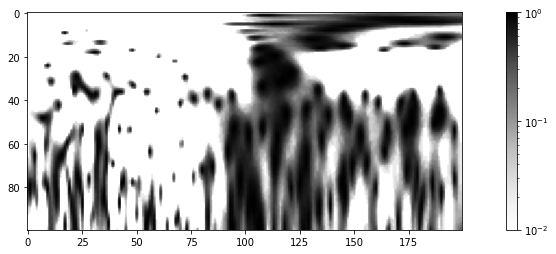

In [38]:
img = plt.imshow(result_wwa_pval, cmap=cmap, norm=LogNorm())
plt.colorbar(img)
pass

In [39]:
pd.DataFrame(result_wwa_pval.flatten()).describe()

,0
count,20000.000000
mean,0.197787
std,0.282511
min,0.000000
25%,0.000000
50%,0.030000
75%,0.340000
max,1.000000


#### Adding more simulations

If we need to simulations to be analysed to reach a lower significance level, it is possible to add upon those that were already analysed by setting the optional argument `append=True`. The existing counts of simulations that produced a stronger signal than the data will be added upon. It is *important* that the user ensures that new simulations added are independent of the previous ones. Repetitions of the same simulation will invalidate the p-values.

By default or by explicitly setting `append=False` the arrays that contain the counts and the p-values are reset to 0, before the new simulations are analysed.

Below we simulated 100 new light curves and add them to the analysis:

In [40]:
n_sim = 100
simulations = [noise(n, x_err) for i in range(n_sim)]
print('{0:d} simulations created.'.format(len(simulations)))

100 simulations created.


In [41]:
wwz.estimate_significance(simulations, append=True)

WWZ instance created.
Starting analysis of simulations at 2021-09-12 14:24:59.352224
Finished in 0:03:16.548583%


True

It is possible to check how many simulations have been analyses in total:

In [42]:
wwz.n_sig

200

Below, we quickly look at the p-value maps for WWZ and WWA:

In [43]:
result_wwz_pval = wwz.wwz_pval.transpose()
result_wwa_pval = wwz.wwa_pval.transpose()

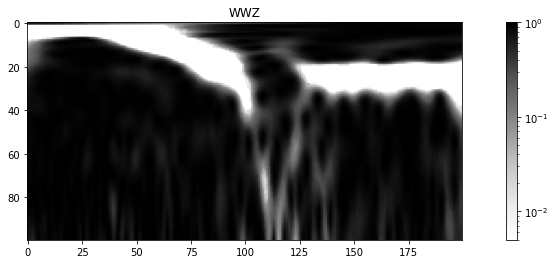

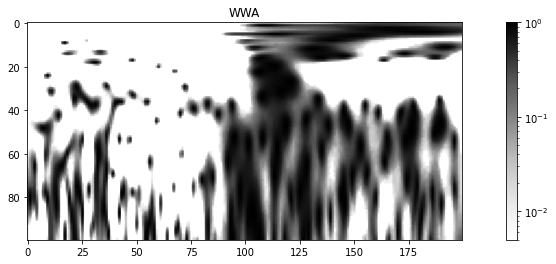

In [44]:
img = plt.imshow(result_wwz_pval, cmap=cmap, norm=LogNorm())
plt.colorbar(img)
plt.title('WWZ')
plt.figure()
img = plt.imshow(result_wwa_pval, cmap=cmap, norm=LogNorm())
plt.colorbar(img)
plt.title('WWA')
pass

## Save and load

If the WWZ analysis requires a long time to run, it may be advantageous to save the result and load it when the results should be further analysed at a later time. The `save` method saves the entire class instance in its current stage to a python pickle file:

In [45]:
wwz.save('wwz_result.pickle')

The `load` method allows to load the class instance from a saved pickle file. Note that this method returns a new instance. If we want to load it to the currenct variable name, we need to assign it as such:

In [46]:
wwz = WWZ()
wwz = wwz.load('wwz_result.pickle')

WWZ instance created.


## Analyzing the WWZ and WWA

### Identifying peaks in the signal

The method `find_peaks()` allows us to find peaks along the frequency/period axis for each time bin, $\tau$. The first argument sets which signal is analysed (`'wwz'`, `'wwa'`<!--, `'wwz_pval'`, `'wwa_pval'`-->). For `'wwz'` or `'wwa'` the method will for each time bin identify all distinct peaks in that signal that exceed a given threshold value. This threshold is given as the second method argument. <!--If the corresponding p-values are analysed, the method will identify all distinct local minima along the freqency/period axis for each time bin. Only minima below the given threshold are accepted. In the case of the p-values the threshold needs to be in the interval `[0,1]`.--> Minima identification in the p-values is currently not available. 

The method returns three arrays. The first contains the time steps, $\tau$, where a peak was found. Note that none or multiple peaks can be identified at a given $\tau$. Therefore, this array is not identical to the initial $\tau$ provided to `WWZ` class instance. The second array contains the corresponding peak positions, i.e. frequencies or periods (see a bit further below). The third array contains the signal strength at the peak position.

The plots below show the peak positions over time. The size indicates the strength of the WWZ. The two examples below demonstrate how different thresholds for the noise level affect the indentification of peaks:

<div class="alert alert-block alert-warning">
<b>TBD</b> Peak identification for the p-values.
</div>

<div class="alert alert-block alert-danger">
<b>TBD</b> The code crashes, when the threshold is chosen too low. Currently, it is not clear what <i>too low</i> is. At the very least this error should be caught and a note to increase the threshold should be printed. Better, understand the origin and come up with a lower limit.
</div>

Finding peaks in WWZ.
Analysis in frequency space.
Done.


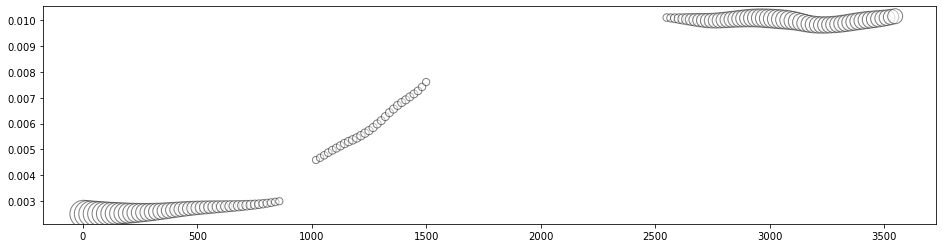

In [49]:
threshold = 50
peak_tau, peak_pos, peak_signal = wwz.find_peaks('wwz', threshold)

plt.scatter(peak_tau, peak_pos, s=peak_signal, color='w', edgecolor='k', alpha=0.5)
pass

Finding peaks in WWZ.
Analysis in frequency space.
Done.


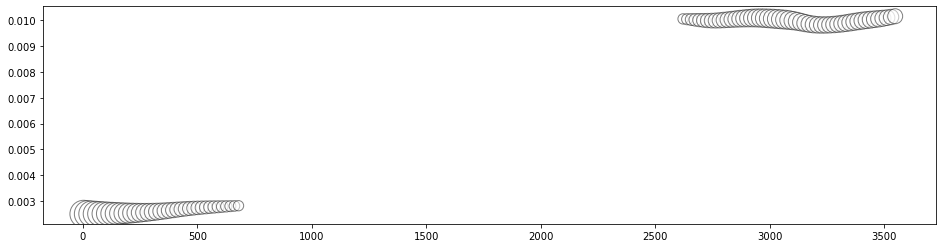

In [50]:
threshold = 100
peak_tau, peak_pos, peak_signal = wwz.find_peaks('wwz', threshold)

plt.scatter(peak_tau, peak_pos, s=peak_signal, color='w', edgecolor='k', alpha=0.5)
pass

The resolution in the peak identification is increased through spline interpolation. Per default, 10 times the sampling of the frequency/period space is used in the evaluation. This number can be changed by setting the optional argument `sampling=10`.

#### Analysis in frequency or period space

By default, the peaks are searched in frequency-space, when the WWZ analysis did not use a linear period scale. The returned peak positions will correspond to frequencies. If a linear period sampling was chosen, the search for peaks will automatically be performed in period space. Accordingly, the returned peak positions will relate to periods.

In either case it is also possible to force the analysis in frequency space by setting `period_space=False` or in period space by setting `period_space=True`. The latter is demonstrated below:

Finding peaks in WWZ.
Analysis in period space.
Done.


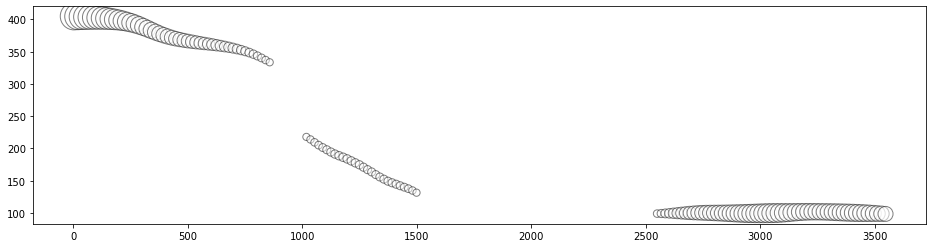

In [51]:
threshold = 50
peak_tau, peak_pos, peak_signal = wwz.find_peaks('wwz', threshold, period_space=True)

plt.scatter(peak_tau, peak_pos, s=peak_signal, color='w', edgecolor='k', alpha=0.5)
pass

## Plotting the WWZ and WWA

<div class="alert alert-block alert-warning">
<b>TBD</b> All plotting methods will be gathered in a special class. Below is just a quick implementation of placing the correct axis ticks and labels.
</div>

In [52]:
linear_period = True

wwz = WWZ(t, x, x_err)
freq = wwz.get_freq(p_max_factor=4, linear_period=linear_period, n_bins=40)
tau = wwz.get_tau(n_bins=50)
wwz.set_freq(freq)
wwz.set_tau(tau)

wwz.transform(verbose=1)
result_wwz = wwz.wwz.transpose()

WWZ instance created.
Data stored.
Linear range of frequencies created with
Shortest period:         2.70e+01
Longest period:          8.86e+02
Period interval:         2.20e+01
Lowest frequency:        1.13e-03
Highest frequency:       3.70e-02
Frequency interval:    non-linear
Number of frequencies:         40

Linear range of tau (time points) created with
Earliest time:                2.8
Latest time:               3547.7
Time interval:               72.3
Points in time:                50

Frequencies set.
Tau (time points) set.
Starting the WWZ transform..
Finished in 0:00:00.251664


In [53]:
from matplotlib.ticker import MaxNLocator, MultipleLocator, FixedLocator

/home/skiehl/bin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide


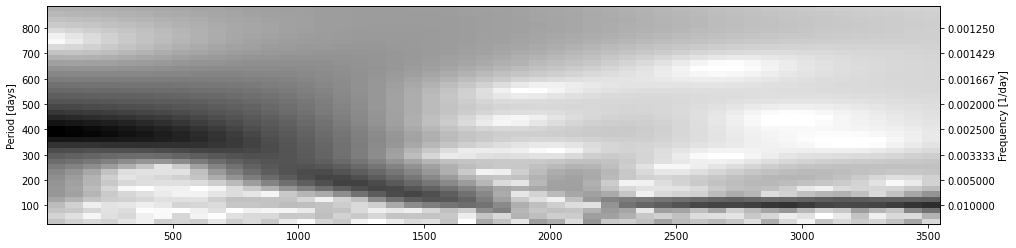

In [54]:
__, ax0 = plt.subplots(1)

if linear_period:
    extent = (tau[0], tau[-1], 1/freq[-1], 1/freq[0])
    ylim = (freq[0], freq[-1])
    label0 = 'Period [days]'
    label1 = 'Frequency [1/day]'
else:
    extent = (tau[0], tau[-1], freq[-1], freq[0])
    ylim = (1/freq[0], 1/freq[-1])
    label0 = 'Frequency [1/day]'
    label1 = 'Period [days]'

cmap = cm.get_cmap('Greys')
im = ax0.imshow(
        result_wwz, cmap=cmap, norm=LogNorm(vmin=result_wwz.min()*1000, vmax=result_wwz.max()),
        origin='upper', aspect='auto', extent=extent)
ax1 = ax0.twinx()
ax1.set_ylim(ylim[0], ylim[1])
conversion = lambda x: 1/x
ax1.set_yscale('function', functions=(conversion, conversion))
test = 1/ax0.get_yticks()[1:-1]
ax1.yaxis.set_major_locator(FixedLocator(test))
ax0.set_ylabel(label0)
ax1.set_ylabel(label1)
pass

<a id='references'></a>

## References

[1] Foster, 1996, https://ui.adsabs.harvard.edu/abs/1996AJ....112.1709F/abstract